# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


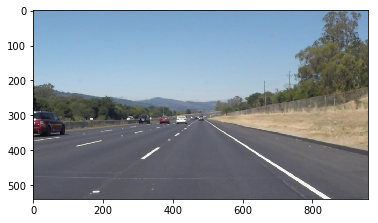

In [2]:
# read in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

# show the image shape and plot the image
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)

## Helper Functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def hsv(img):
    """Applies the HSV transforam
    """
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    
    The points are averaged with the points from the previous frame
    to make the lines on the video appear smoother.
    """
    # top and bottom y-coordinates
    imshape = img.shape
    top_y = imshape[0] * 0.6
    bottom_y = imshape[0]

    # points list
    left_x1_list =[]
    left_x2_list = []
    right_x1_list =[]
    right_x2_list =[]

    for line in lines:
        for x1,y1,x2,y2 in line:
            # add points to list
            if 0.5 < (y2 - y1)/(x2 - x1) < 0.8:
                m, b = np.polyfit([x1, x2], [y1, y2], 1)
                left_x1_list.append(np.int((top_y - b) / m))
                left_x2_list.append(np.int((bottom_y - b) / m))
                
            elif -0.8 < (y2 - y1)/(x2 - x1) < -0.5:
                m, b = np.polyfit([x1, x2], [y1, y2], 1)                
                right_x1_list.append(np.int((top_y - b) / m))
                right_x2_list.append(np.int((bottom_y - b) / m))
    
    # average with previous frame
    global left_avg_x1, left_avg_x2, right_avg_x1, right_avg_x2
    # run for first frame and run for frames after missing points are found
    if left_avg_x1 or left_avg_x2 or right_avg_x1 or right_avg_x2 == 0:
        # find average points
        try:
            left_avg_x1 = np.int(np.nanmean(left_x1_list))
            left_avg_x2 = np.int(np.nanmean(left_x2_list))
            right_avg_x1 = np.int(np.nanmean(right_x1_list))
            right_avg_x2 = np.int(np.nanmean(right_x2_list))
        except ValueError:
            pass
    # run after frames with all points found
    else:
        try:
            left_avg_x1 = np.mean(left_avg_x1, np.int(np.nanmean(left_x1_list)))
            left_avg_x2 = np.mean(left_avg_x2, np.int(np.nanmean(left_x2_list)))
            right_avg_x1 = np.mean(right_avg_x1, np.int(np.nanmean(right_x1_list)))
            right_avg_x2 = np.mean(right_avg_x2, np.int(np.nanmean(right_x2_list)))
        except ValueError:
            pass
    # draw lines
    cv2.line(img, (left_avg_x1, int(top_y)), (left_avg_x2, bottom_y), color, thickness)
    cv2.line(img, (right_avg_x1, int(top_y)), (right_avg_x2, bottom_y), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """   
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    initial_img * α + img * β + λ
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Lane Finding Pipeline



In [4]:
# Define set of processes
def process_image(image):
   
    # convert image to hsv
    hsv_img = hsv(image)

    # define hsv ranges for yellow and white
    lower_yellow = np.array([20, 100, 100]) 
    upper_yellow = np.array([35, 255, 255]) 
    lower_white = np.array([0, 0, 230]) 
    upper_white = np.array([180, 25, 255])
    
    # threshold hsv_img with defined ranges
    yellow_hsv = cv2.inRange(hsv_img, lower_yellow, upper_yellow)
    white_hsv = cv2.inRange(hsv_img, lower_white, upper_white)
    hsv_mask_img = cv2.bitwise_or(yellow_hsv, white_hsv)
    
    # blur image
    blurred_img = gaussian_blur(hsv_mask_img, 3)
    
    # apply canny edge detection
    edge_img = canny(blurred_img, 50, 150)
    
    # define and mask region of interest
    imshape = image.shape
    height = imshape[0]
    width = imshape[1]
    vertices = np.array([[(width * 0.05, height),(width * 0.48, height * 0.6), \
                          (width * 0.52, height * 0.6), (width * 0.95, height)]], dtype = np.int32)
    masked_img = region_of_interest(blurred_img, vertices)
    
    # define and apply hough transformation
    hough_rho = 1
    hough_theta = np.pi/180
    hough_threshold = 80
    hough_min_line_len = 80
    hough_max_line_gap = 250
    hough_img = hough_lines(masked_img, hough_rho, hough_theta, hough_threshold, hough_min_line_len, hough_max_line_gap)
    
    # show final image
    final_img = weighted_img(hough_img, image)
    return final_img

## Test Images

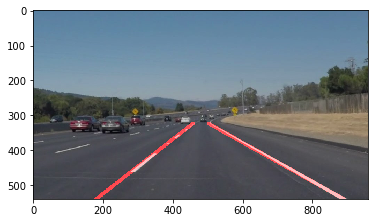

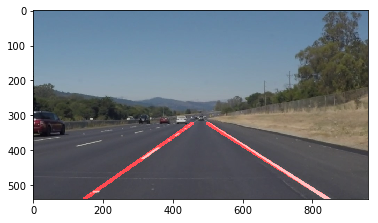

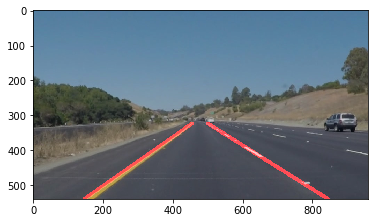

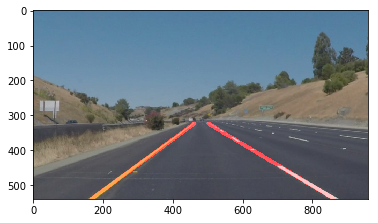

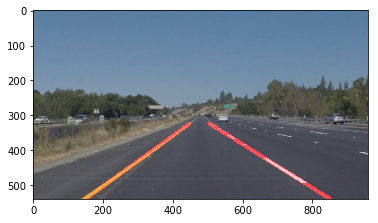

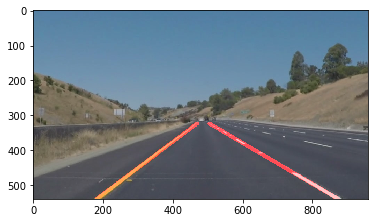

In [13]:
# intialize gobal variables
left_avg_x1 = 0
left_avg_x2 = 0
right_avg_x1 = 0
right_avg_x2 = 0

import os
image_list = []
for filename in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + filename)
    image_list.append(image)
    result = process_image(image)
    
    plt.figure()
    plt.imshow(result, cmap = "gray")
    
    #r, g, b = cv2.split(result)
    #result = cv2.merge((b, g, r))
    #cv2.imwrite("outputs/output_" + filename, result)

## Test on Videos

In [6]:
# import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

### First video with solid white lane on the right

In [7]:
# initialize gobal variables
left_avg_x1 = 0
left_avg_x2 = 0
right_avg_x1 = 0
right_avg_x2 = 0

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 221/222 [00:05<00:00, 43.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 5.69 s


In [8]:
# show the video output
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Second video with solid yellow lane on the left

In [9]:
# initialize gobal variables
left_avg_x1 = 0
left_avg_x2 = 0
right_avg_x1 = 0
right_avg_x2 = 0

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [00:15<00:00, 42.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 16.5 s


In [10]:
# show the video output
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

### Third video with curves and shadows

In [11]:
# initialize gobal variables
left_avg_x1 = 0
left_avg_x2 = 0
right_avg_x1 = 0
right_avg_x2 = 0

challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:09<00:00, 26.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 10.6 s


In [12]:
# show the video output
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))